In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sigma = 15
datestart, dateend = "2012-01-01", "2012-01-25"
experiment_name = "INALT60.L120-KRS0020"  
data_resolution = "1d" 

In [4]:
data_path = f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{experiment_name}/nemo/'
mesh_mask = xr.open_dataset(data_path + 'suppl/2_INALT60.L120-KRS0020_mesh_mask.nc')
u_ds = xr.open_mfdataset(data_path + f'output/2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_U.nc', chunks={'time_counter': 50})
v_ds = xr.open_mfdataset(data_path + f'output/2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_V.nc', chunks={'time_counter': 50})

In [ ]:
# smoothed
u_ds_smoothed = xr.open_dataset(
    f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
    f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_U.nc',
    chunks={'time_counter': 50}
)
v_ds_smoothed = xr.open_dataset(
    f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
    f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_V.nc',
    chunks={'time_counter': 50}
)

FileNotFoundError: [Errno 2] No such file or directory: b'/gxfs_work/geomar/smomw523/smoothed_data/INALT60.L120-KRS0020/2_INALT60.L120-KRS0020_1d_20120101_20120125_smoothed_15_grid_V.nc'

In [6]:
u = u_ds.isel(depthu=0, time_counter = 0).vozocrtx
v = v_ds.isel(depthv=0, time_counter = 0).vomecrty

u_depth = u.rename({'depthu': 'depth'})
v_depth = v.rename({'depthv': 'depth'})

vel_INALT = xr.combine_by_coords([u_depth, v_depth], compat='override', combine_attrs='drop_conflicts')
vel_INALT["vel"] = np.sqrt(vel_INALT.vomecrty**2 + vel_INALT.vozocrtx**2)
vel_INALT = vel_INALT.compute()

In [7]:
# smoothed
u_smoothed = u_ds_smoothed.isel(depthu=0, time_counter = 0).vozocrtx
v_smoothed = v_ds_smoothed.isel(depthv=0, time_counter = 0).vomecrty

u_smoothed_depth = u_smoothed.rename({'depthu': 'depth'})
v_smoothed_depth = v_smoothed.rename({'depthv': 'depth'})

vel_INALT_smoothed = xr.combine_by_coords([u_smoothed_depth, v_smoothed_depth], compat='override', combine_attrs='drop_conflicts')
vel_INALT_smoothed["vel"] = np.sqrt(vel_INALT_smoothed.vomecrty**2 + vel_INALT_smoothed.vozocrtx**2)
vel_INALT_smoothed = vel_INALT_smoothed.compute()

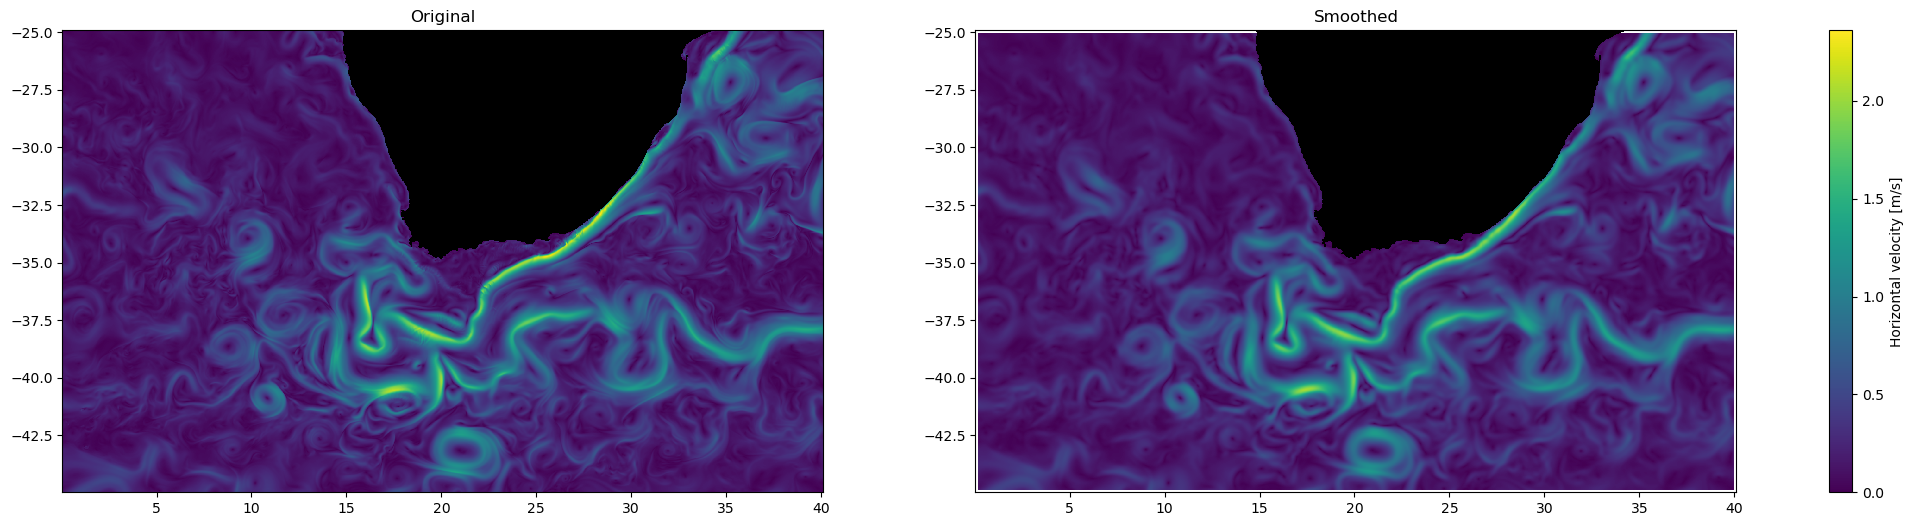

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))  
vmin = min(vel_INALT.vel.min(), vel_INALT_smoothed.vel.min())
vmax = max(vel_INALT.vel.max(), vel_INALT_smoothed.vel.max())

cm1 = axes[0].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, vel_INALT.vel, vmin=vmin, vmax=vmax)
axes[0].contourf(mesh_mask.nav_lon, mesh_mask.nav_lat, 
                 mesh_mask.isel(z=0, t=0).tmask.where(mesh_mask.isel(z=0, t=0).tmask == 0), 
                 colors='black')
axes[0].set_title("Original")

cm2 = axes[1].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, vel_INALT_smoothed.vel, vmin=vmin, vmax=vmax)
axes[1].contourf(mesh_mask.nav_lon, mesh_mask.nav_lat, 
                 mesh_mask.isel(z=0, t=0).tmask.where(mesh_mask.isel(z=0, t=0).tmask == 0), 
                 colors='black')
axes[1].set_title("Smoothed")

cbar = fig.colorbar(cm1, ax=axes, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label("Horizontal velocity [m/s]")


In [9]:
dudy = (u_depth - u_depth.shift(y=1)) / mesh_mask.e2t # meridional derivative on F-grid
dvdx = (v_depth - v_depth.shift(x=1)) / mesh_mask.e1t # zonal derivative on F-grid
f = mesh_mask.ff # (from mesh_mask.nc) # alternatively: 2 * 7.2921e-5 * xr.ufuncs.sin(2 * 3.14159265359 * gphif / 360) # planetary vorticity on the F-grid
vort = (dvdx - dudy) / f # normalized relative vorticity on F-grid

In [10]:
# smoothed
dudy_smoothed = (u_smoothed_depth - u_smoothed_depth.shift(y=1)) / mesh_mask.e2t # meridional derivative on F-grid
dvdx_smoothed = (v_smoothed_depth - v_smoothed_depth.shift(x=1)) / mesh_mask.e1t # zonal derivative on F-grid
vort_smoothed = (dvdx_smoothed - dudy_smoothed) / f # normalized relative vorticity on F-grid

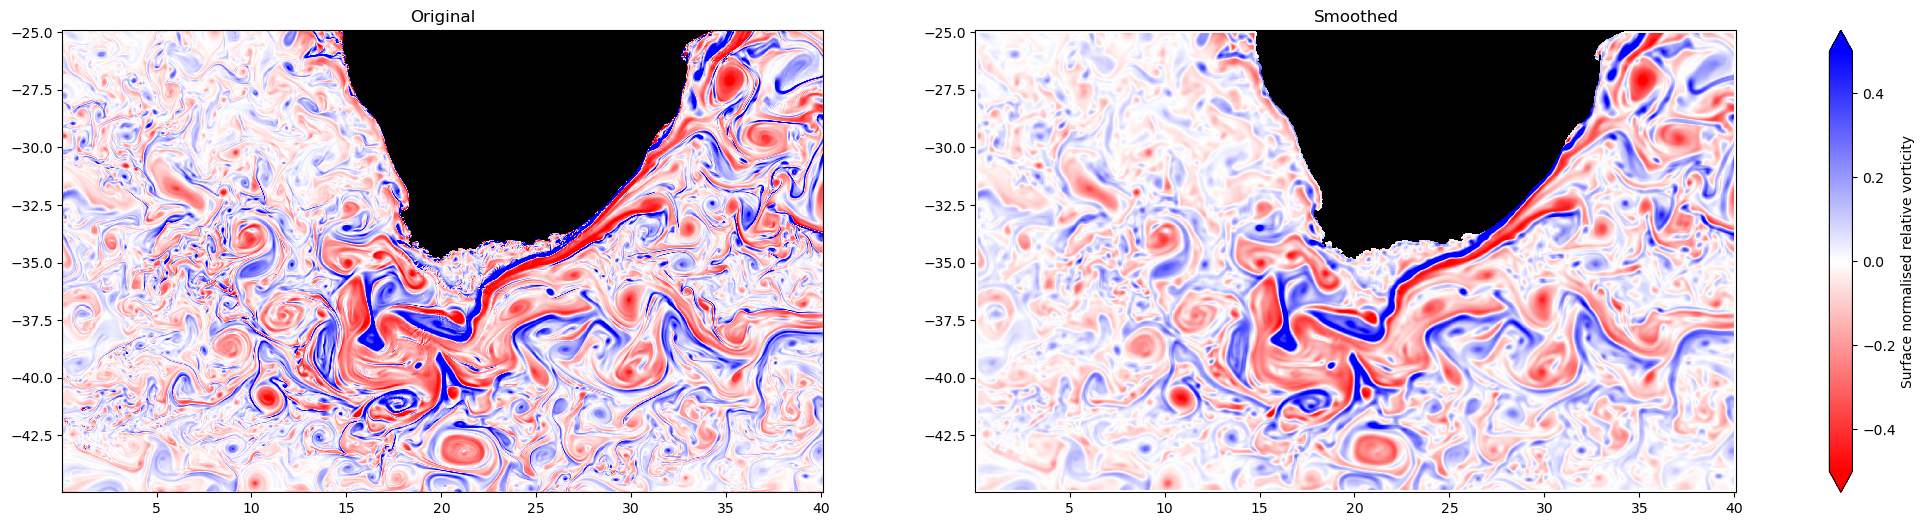

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

vmin = -0.5 #min(vort.min(), vort_smoothed.min()).values
vmax = 0.5 #max(vort.max(), vort_smoothed.max()).values

cm1 = axes[0].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, vort.isel(t=0), vmin=vmin, vmax=vmax,cmap='bwr_r')
axes[0].contourf(mesh_mask.nav_lon, mesh_mask.nav_lat, 
                 mesh_mask.isel(z=0, t=0).tmask.where(mesh_mask.isel(z=0, t=0).tmask == 0), 
                 colors='black')
axes[0].set_title("Original")

cm2 = axes[1].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, vort_smoothed.isel(t=0), vmin=vmin, vmax=vmax,cmap='bwr_r')
axes[1].contourf(mesh_mask.nav_lon, mesh_mask.nav_lat, 
                 mesh_mask.isel(z=0, t=0).tmask.where(mesh_mask.isel(z=0, t=0).tmask == 0), 
                 colors='black')
axes[1].set_title("Smoothed")

cbar = fig.colorbar(cm1, ax=axes, orientation='vertical', fraction=0.05, pad=0.05, extend='both')
cbar.set_label("Surface normalised relative vorticity")